In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [21]:
taxi_zones = gpd.read_file('./taxi_zones__7_/taxi_zones.shp')

In [ ]:
rides_2019 = pd.read_csv('turnstile_daily_counts_2019.csv')
rides_2020 = pd.read_csv('turnstile_daily_counts_2020.csv')

In [ ]:
rides_2019['date'] = pd.to_datetime(rides_2019['date'])
rides_2020['date'] = pd.to_datetime(rides_2020['date'])


In [ ]:
#filter rides to obersation period of may 6th to August 31st

rides_2019 = rides_2019[(rides_2019['date'] > datetime(year=2019, month=5, day=6))\
           & (rides_2019['date'] > datetime(year=2019, month=8, day=31))]

rides_2020 = rides_2020[(rides_2020['date'] > datetime(year=2020, month=5, day=6))\
           & (rides_2020['date'] > datetime(year=2020, month=8, day=31))] 

In [ ]:
#group by station

rides2019_station = rides_2019.groupby('stop_name')\
    .agg({'gtfs_longitude':'mean', 'gtfs_latitude':'mean','entries':'sum','exits':'sum'})\
    .rename(columns={'entries':'2019_entries','exits':'2019_exits'}).reset_index()
        
rides2020_station = rides_2020.groupby('stop_name')\
    .agg({'gtfs_longitude':'mean', 'gtfs_latitude':'mean','entries':'sum','exits':'sum'})\
    .rename(columns={'entries':'2020_entries','exits':'2020_exits'}).reset_index()


In [ ]:
# Update some station names from 2019

rides2019_station.loc[rides2019_station.stop_name == '5 Av','stop_name'] = '42 St - Bryant Pk'
rides2019_station.loc[rides2019_station.stop_name == '74 St - Broadway','stop_name'] = 'Jackson Hts - Roosevelt Av'
rides2019_station.loc[rides2019_station.stop_name == 'Bleecker St','stop_name'] = 'Broadway-Lafayette St'
rides2019_station.loc[rides2019_station.stop_name == '14 St - Union Sq','stop_name'] = 'Union Sq - 14 St'
rides2019_station.loc[rides2019_station.stop_name == 'Brooklyn Bridge - City Hall','stop_name'] = 'City Hall'
rides2019_station.loc[rides2019_station.stop_name == '168 St','stop_name'] = '168 St - Washington Hts'
rides2019_station.loc[rides2019_station.stop_name == 'Whitehall St','stop_name'] = 'South Ferry'


In [8]:
#stops that appear in 2019 but not 2020
np.setdiff1d(rides2019_station.stop_name, rides2020_station.stop_name)

array(['Botanic Garden', 'Lexington Av/59 St'], dtype=object)

In [9]:
#stop that appear in 2020 but not 2019
np.setdiff1d(rides2020_station.stop_name, rides2019_station.stop_name)

array(['149 St - Grand Concourse', '4 Av', '49 St', 'Cortlandt St',
       'Howard Beach', 'Jamaica'], dtype=object)

In [50]:
#merge into single data frame

station_rides = rides2019_station.merge(rides2020_station\
                .drop(columns=['gtfs_longitude','gtfs_latitude']), on='stop_name', how='inner')

# add point geometry

station_rides = gpd.gpd.GeoDataFrame(
    station_rides, geometry=gpd.points_from_xy(station_rides.gtfs_longitude, station_rides.gtfs_latitude))\
        .drop(columns=['gtfs_latitude','gtfs_longitude'])

#station_rides.geometry = station_rides.geometry.buffer(.01)

station_rides = station_rides.set_crs('EPSG:4326')

In [12]:
#change crs projecting of taxi zones if needed

#taxi_zones = taxi_zones.to_crs(4326)

In [13]:
# try subway stop shapefile instead

subway_stops_geo = gpd.read_file('./stops_nyc_subway/stops_nyc_subway_nov2020.shp')

In [14]:
#subway_stops_geo.to_crs(4326)

In [51]:
station_rides1 = subway_stops_geo[['stop_id','stop_name','geometry']].merge(station_rides.iloc[:,:-1], on='stop_name')

In [67]:
station_rides1.geometry = station_rides1.geometry.buffer(100)

<AxesSubplot:>

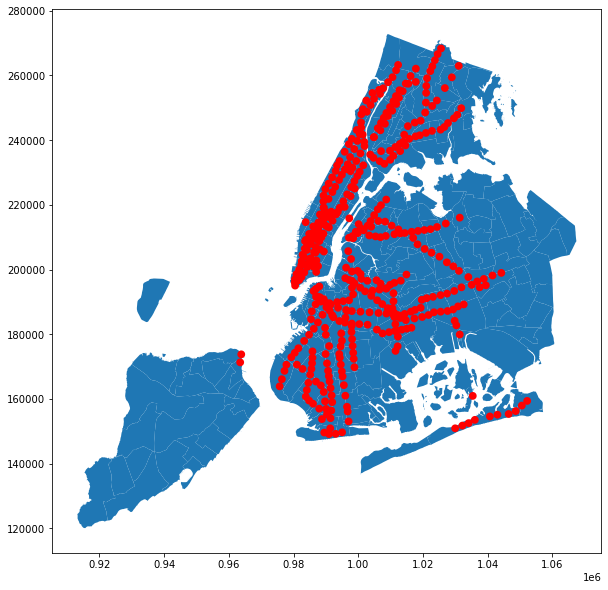

In [68]:
figure, ax = plt.subplots(figsize=(10,10))


taxi_zones.plot(ax=ax)
station_rides1.plot(ax=ax, color='red')

In [69]:
rides_geo = gpd.sjoin(taxi_zones, station_rides1, how='left', op='intersects')

In [70]:
gpd.sjoin(taxi_zones, station_rides1, how='left', op='intersects')


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,index_right,stop_id,stop_name,2019_entries,2019_exits,2020_entries,2020_exits
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",428.0,H04,Broad Channel,31461.0,8096.0,11095.0,5781.0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",13.0,504,Pelham Pkwy,1233791.0,652433.0,447766.0,348032.0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",9.0,503,Gun Hill Rd,1131857.0,1101336.0,419579.0,626860.0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",212.0,L06,1 Av,1709935.0,1910492.0,659219.0,920326.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",95.0,Q05,96 St,8832677.0,6932508.0,2537872.0,2607447.0
262,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",93.0,625,96 St,8832677.0,6932508.0,2537872.0,2607447.0
262,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",165.0,627,77 St,3278776.0,2915590.0,1064298.0,1176954.0
262,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",99.0,Q04,86 St,12063628.0,10638269.0,3333199.0,3792983.0


In [71]:
ridesbyzone = rides_geo.groupby(['LocationID','zone'])[['2019_entries','2019_exits','2020_entries','2020_exits']].sum()

In [72]:
ridesbyzone

,,2019_entries,2019_exits,2020_entries,2020_exits
LocationID,zone,,,,
1,Newark Airport,0.0,0.0,0.0,0.0
2,Jamaica Bay,31461.0,8096.0,11095.0,5781.0
3,Allerton/Pelham Gardens,2365648.0,1753769.0,867345.0,974892.0
4,Alphabet City,1709935.0,1910492.0,659219.0,920326.0
5,Arden Heights,0.0,0.0,0.0,0.0
...,...,...,...,...,...
259,Woodlawn/Wakefield,1287865.0,830347.0,569841.0,468474.0
260,Woodside,12199096.0,10724263.0,4519118.0,4693160.0
261,World Trade Center,79271678.0,68982089.0,14140502.0,16217816.0


In [73]:
ridesbyzone['entries_pct_change'] = (ridesbyzone['2020_entries'] - ridesbyzone['2019_entries']) / (ridesbyzone['2019_entries'])
ridesbyzone['exits_pct_change'] = (ridesbyzone['2020_exits'] - ridesbyzone['2019_exits']) / (ridesbyzone['2019_exits'])


In [74]:
ridesbyzone = ridesbyzone.reset_index()

In [76]:
ridesbyzone

,LocationID,zone,2019_entries,2019_exits,2020_entries,2020_exits,entries_pct_change,exits_pct_change
0,1,Newark Airport,0.0,0.0,0.0,0.0,NaN,NaN
1,2,Jamaica Bay,31461.0,8096.0,11095.0,5781.0,-0.647341,-0.285944
2,3,Allerton/Pelham Gardens,2365648.0,1753769.0,867345.0,974892.0,-0.633358,-0.444116
3,4,Alphabet City,1709935.0,1910492.0,659219.0,920326.0,-0.614477,-0.518278
4,5,Arden Heights,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...
255,259,Woodlawn/Wakefield,1287865.0,830347.0,569841.0,468474.0,-0.557530,-0.435809
256,260,Woodside,12199096.0,10724263.0,4519118.0,4693160.0,-0.629553,-0.562379
257,261,World Trade Center,79271678.0,68982089.0,14140502.0,16217816.0,-0.821620,-0.764898
258,262,Yorkville East,20896305.0,17570777.0,5871071.0,6400430.0,-0.719038,-0.635734
